To begin, I need to import pandas and use it to load my dataset of all billionaires.

In [1]:
import pandas as pd

#import the complete Billionares Statistics Dataset from Kaggle
billionaires = pd.read_csv("Billionaires Statistics Dataset.csv")

#inspect the data
#print(billionaires.head())
#print(billionaires.info())



Upon reviewing the data, I have decided to focus my analysis specifically on billionaires from or in the United States.

In [2]:
#create a new dataframe including only billionaires with ciitizenship in the United States or billionaires that reside in the United States
us_billionaires = billionaires[(billionaires.countryOfCitizenship == "United States") | (billionaires.country == "United States")]

#investigate whether "industries" and "categories" are the same columns
#print(us_billionaires[(us_billionaires.industries) != (us_billionaires.category)].count())


With the new dataframe created, I can begin cleaning the data.


In [3]:
#Get info on the new dataset
#print(us_billionaires.info())

#Although there are people from outside the US included in this dataset, there aren't enough to warrant keeping country-specific information in the dataset.
    #It won't be used in my analyis and is repeated across almost all rows
#Certain other columns are also repeated or otherwise unnecessary for analysis, such as firstName, lastName, birthYear, birthMonth, birthDay.
#I plan on using Tableau to construct a visualization of this data afterward which includes geographic data, so longitude and latitude can be removed as well. 

dropped_us_billionaires = us_billionaires.drop(["cpi_country", "cpi_change_country", \
                                        "gdp_country", "gross_tertiary_education_enrollment", \
                                        "gross_primary_education_enrollment_country", "life_expectancy_country", \
                                        "tax_revenue_country_country", "total_tax_rate_country",
                                        "population_country", "firstName", "lastName", \
                                        "birthYear", "birthMonth", "birthDay", "latitude_country", "longitude_country"], axis=1)

#Now I can reinspect the dataset and deal with null values
#Get info on the dataset
#print(dropped_us_billionaires.isnull().sum())

#It seems that the following columns have null values:
    #Country (1)
    #City (5)
    #Organization (529!)
    #Title (514!)
    #State (23)
    #residenceStateRegion (29)

#Starting with Country:
#Check the row that is missing it's Country value
#print(dropped_us_billionaires[dropped_us_billionaires.country.isnull()])

#"Stephen Butt & Family" do not have a country of residence but they do have a country of citizenship. We could use that as a substitute for this missing data.
#Check to see what percent of billionaires reside in their country of citizenship.
#print(len(dropped_us_billionaires[dropped_us_billionaires.country == dropped_us_billionaires.countryOfCitizenship])/len(dropped_us_billionaires))

#With 90% of billionaires residing in their country of citizenship, I am comfortable replacing the null value with "United States" for "Stephen Butt & Family"
#Though it introduces error, removing the point would introduce further error.
#Replace the missing country value with "United States"
dropped_us_billionaires["country"].fillna("United States", inplace=True)


#Onto City
#Check the rows that are missing their City value
#print(dropped_us_billionaires[dropped_us_billionaires.city.isnull()])

#There are 5 missing city values. Unfortunately, this information can't be assumed like the previous.
#I'll use "Unknown" to fill in the city values.
dropped_us_billionaires["city"].fillna("Unknown", inplace=True)


#Next is Organization with 529 missing values! With this much missing data, it may be safer to drop the column.
#Though some of the values are supposed to be missing as not all billionaires have an associated Organization, far too much is missing to be useful for analysis.
#The same can be said for Title. With 514 missing values, it may be safer to drop the column than to draw conclusions.
#Drop the organization and title columns
dropped_us_billionaires2 = dropped_us_billionaires.drop(["organization", "title"], axis=1)


#State is next with 23 missing values. Far less than the columns before.
#Investigate the null data
#print(dropped_us_billionaires2[dropped_us_billionaires2.state.isnull()])

#Some of the billionaires reside outside of the United States, therefore "State" should be missing
#For those in the United States, the information could be recovered if a proper city were provided, but this isn't the case.
#Those outside the United States should have their missing values changed to "N/A" and those in the United States should be changed to "Unknown"

#establish the conditions
c1 = dropped_us_billionaires2.country != "United States"
c2 = dropped_us_billionaires2.country == "United States"
#use the conditions to replace the state column appropriately
dropped_us_billionaires2.loc[c1, "state"] = dropped_us_billionaires2.loc[c1, "state"].fillna("N/A")
dropped_us_billionaires2.loc[c2, "state"] = dropped_us_billionaires2.loc[c2, "state"].fillna("Unknown")
#verify that it worked
#print(dropped_us_billionaires2.info())
#print(dropped_us_billionaires2.state.unique())


#Last is residenceStateRegion which follows the same logic as state above. C1 and C2 can be reused
#Those outside the United States should have the null value replaced with "N/A"
#Those inside the United States should have the null value replaced with "N/A"

#use the conditions to replace the state column appropriately
dropped_us_billionaires2.loc[c1, "residenceStateRegion"] = dropped_us_billionaires2.loc[c1, "residenceStateRegion"].fillna("N/A")
dropped_us_billionaires2.loc[c2, "residenceStateRegion"] = dropped_us_billionaires2.loc[c2, "residenceStateRegion"].fillna("Unknown")
#verify that it worked
#print(dropped_us_billionaires2.info())
#print(dropped_us_billionaires2.residenceStateRegion.unique())


#Now that everything has been dropped, we can reset our index with the remaining values
#I'll also add +1 to each index so that it functions as a ranking of the remaining values as well

#reset the index
dropped_us_billionaires2 = dropped_us_billionaires2.reset_index(drop=True)
#add 1 to the index so that it starts at 1
dropped_us_billionaires2.index = dropped_us_billionaires2.index + 1

#Some of the remaining columns should also be renamed for clarity.
dropped_us_billionaires2 = dropped_us_billionaires2.rename(columns={"rank":"worldwideRanking", "country":"countryOfResidence"})
print(dropped_us_billionaires2.info())

#When going to rename the columns for clarity, I learned that every value in the category column is the same as the value in the industries column.
#print(dropped_us_billionaires2.info())
#print(dropped_us_billionaires2[dropped_us_billionaires2.category == dropped_us_billionaires2.industries].info())

#Therefore, to avoid redundancy, "category" will be dropped too.
#The final cleaned dataframe will be created as well.
billionaires_cleaned = dropped_us_billionaires2.drop(["category"], axis=1)\

#Finally, the values can be re-ranked as "USRanking" since it represents the ranking of the remaining US Billionaires
billionaires_cleaned["USRanking"] = billionaires_cleaned.finalWorth.rank(ascending=False, method="min").astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 1 to 776
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   worldwideRanking      776 non-null    int64  
 1   finalWorth            776 non-null    int64  
 2   category              776 non-null    object 
 3   personName            776 non-null    object 
 4   age                   776 non-null    float64
 5   countryOfResidence    776 non-null    object 
 6   city                  776 non-null    object 
 7   source                776 non-null    object 
 8   industries            776 non-null    object 
 9   countryOfCitizenship  776 non-null    object 
 10  selfMade              776 non-null    bool   
 11  status                776 non-null    object 
 12  gender                776 non-null    object 
 13  birthDate             776 non-null    object 
 14  date                  776 non-null    object 
 15  state                 7

Now that the null values are dealt with, I can begin analysis.

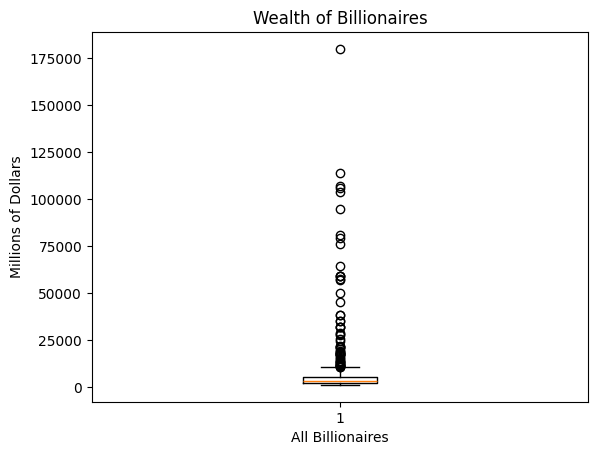

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt

#First I'll use a boxplot to check for any outliers in the finalWorth column

plt.boxplot(billionaires_cleaned.finalWorth)
plt.xlabel("All Billionaires")
plt.ylabel("Millions of Dollars")
plt.title("Wealth of Billionaires")
plt.show()
plt.clf()

#It looks like the data is heavilly skewed to the right. All of the outliers are significantly above the average.
#This means that many billionaires stay at just above 1 billion dollars, but some earn significantly more than average.



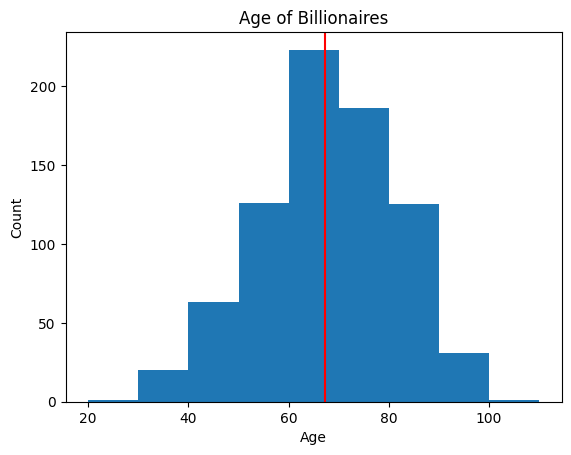

<Figure size 640x480 with 0 Axes>

In [5]:


#Next I'll investigate the distribution of ages using a histogram. A red line will be added at the mean to help with analysis.

bins = [20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

plt.hist(billionaires_cleaned.age, bins=bins)
plt.axvline(x = billionaires_cleaned.age.mean(), color = "red")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age of Billionaires")
plt.show()
plt.clf()

#The data appears to be mostly normal with some skewing to the left. This means that there are more relatively young billionaires than there are relatively old billionaires.
#This makes sense with the mean as shown around 67 years old. It is more likely to find someone significantly younger than it is to find someone significantly older



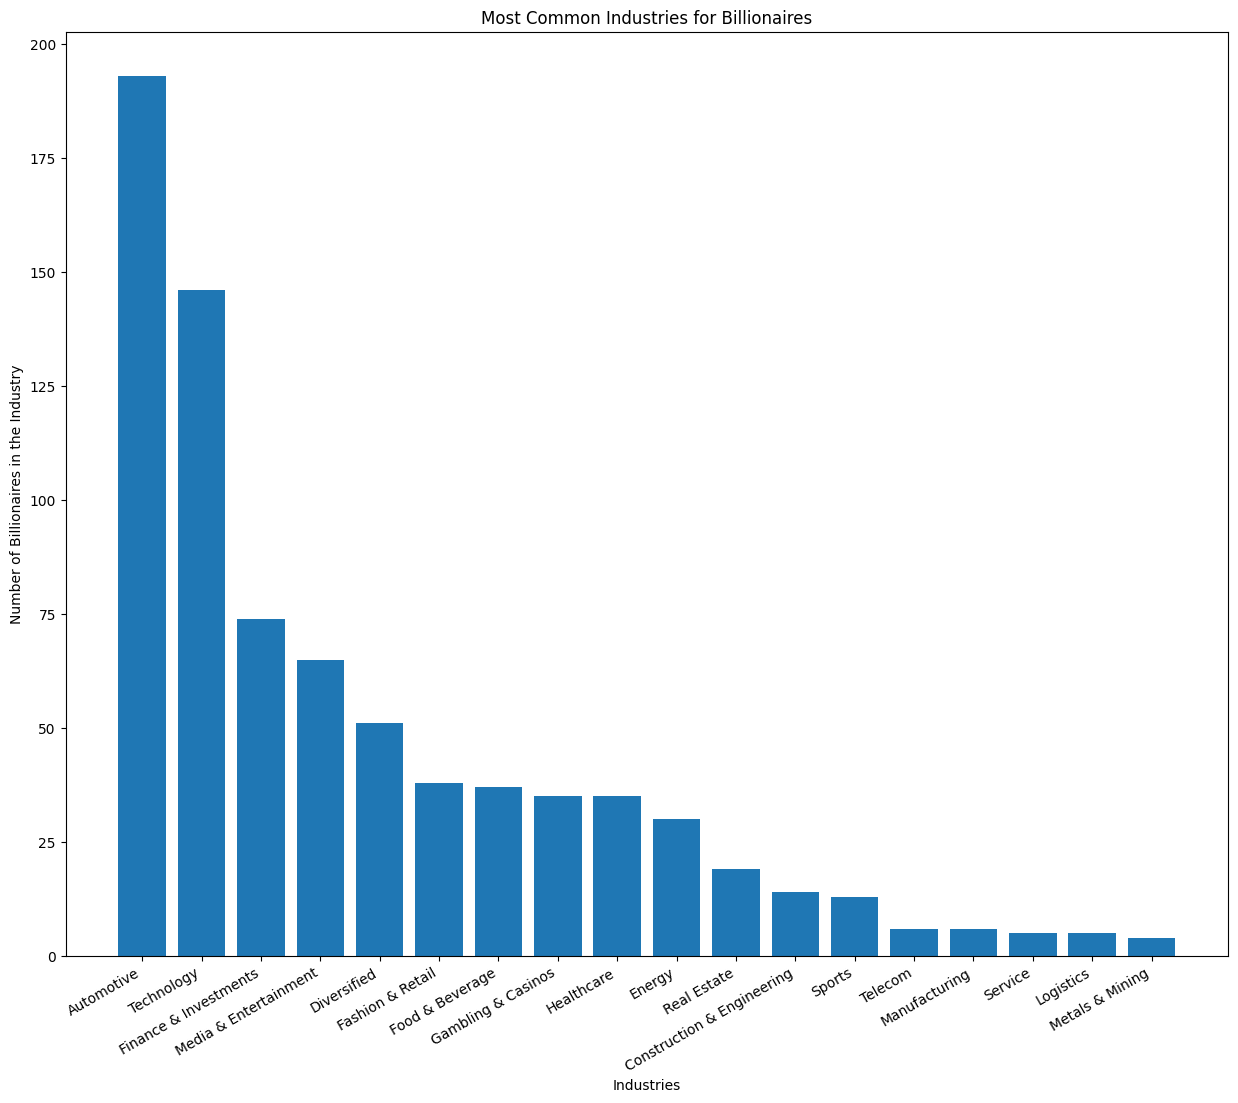

<Figure size 640x480 with 0 Axes>

In [6]:


#Using a bar chart, I'll investigate which industries are most common for billioniares to be involved in

x = billionaires_cleaned.industries.unique()
y = billionaires_cleaned.industries.value_counts()

plt.figure(figsize=(15,12))
plt.bar(x, y)
plt.xticks(rotation=30, ha="right")
plt.xlabel("Industries")
plt.ylabel("Number of Billionaires in the Industry")
plt.title("Most Common Industries for Billionaires")
plt.show()
plt.clf()

#It seems that Automotive, Tech, and Finance are the most common for billionaires while Metals and Mining and Logistics are less common.



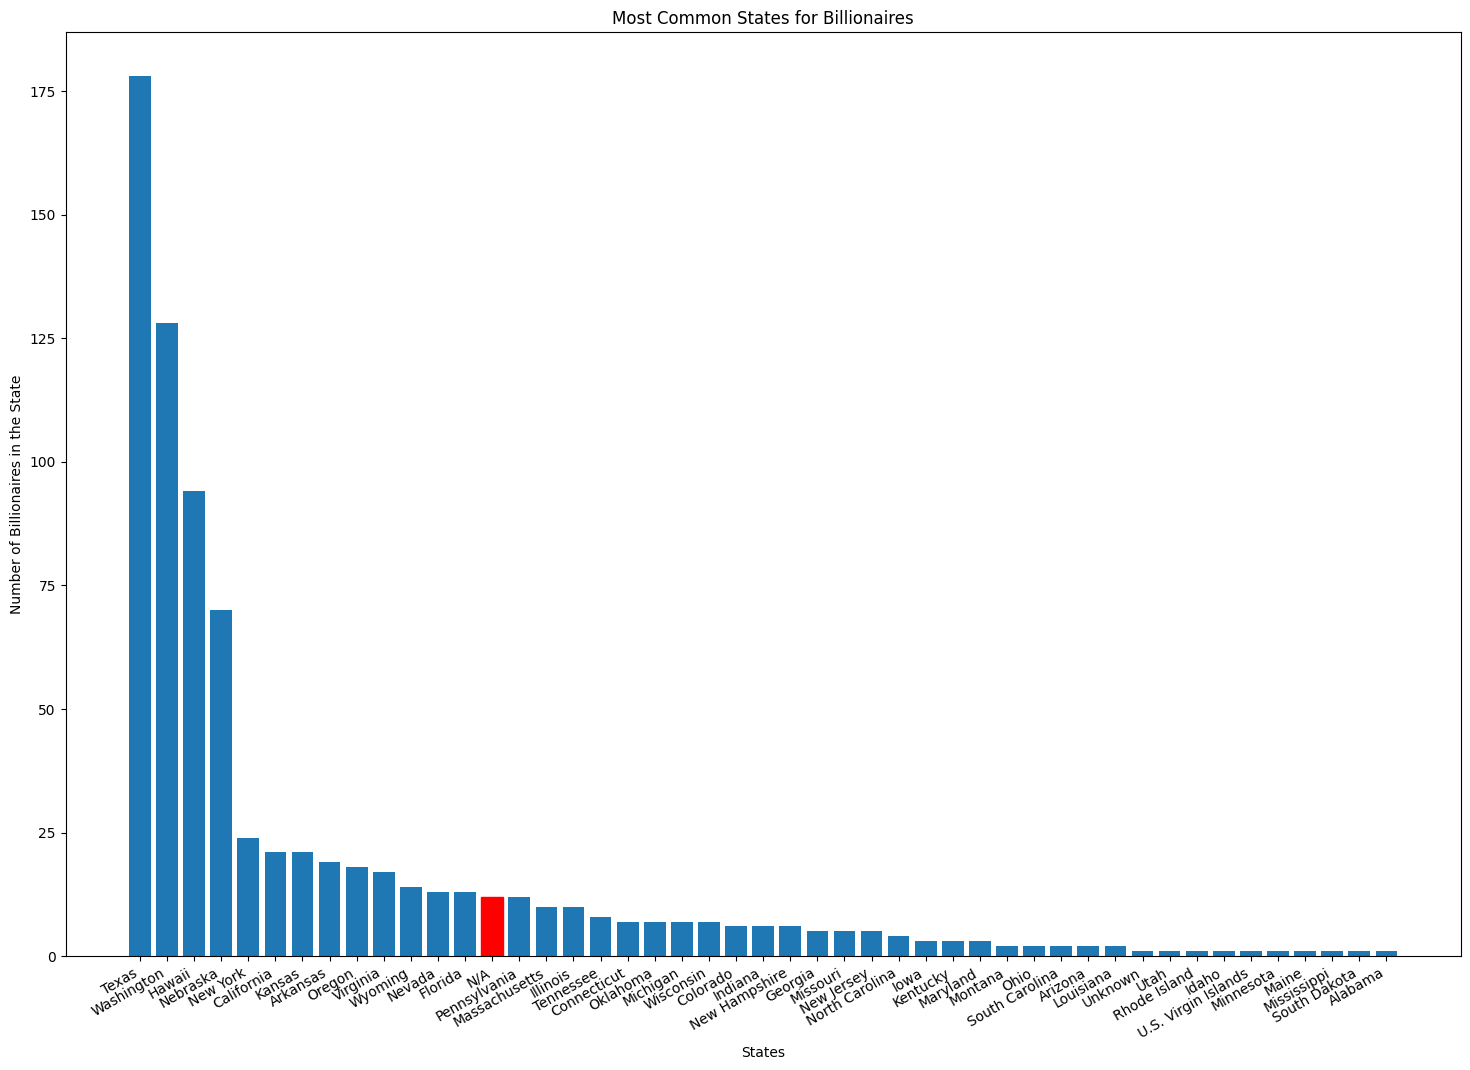

<Figure size 640x480 with 0 Axes>

In [7]:


#I also want to see which state has the most billionaires. The "N/A" column for those that live outside the US has been made red to differentiate it from the rest of the data. 

x = billionaires_cleaned.state.unique()
y = billionaires_cleaned.state.value_counts()

plt.figure(figsize=(18,12))
bargraph = plt.bar(x, y)
bargraph[13].set_color("r")
plt.xticks(rotation=30, ha="right")
plt.xlabel("States")
plt.ylabel("Number of Billionaires in the State")
plt.title("Most Common States for Billionaires")
plt.show()
plt.clf()

#It seems that Texas, Washington, and Hawaii have the most billionaires living there.
#It was also interesting to discover that a majority of US states have fewer American billionaires locally than the rest of the world does



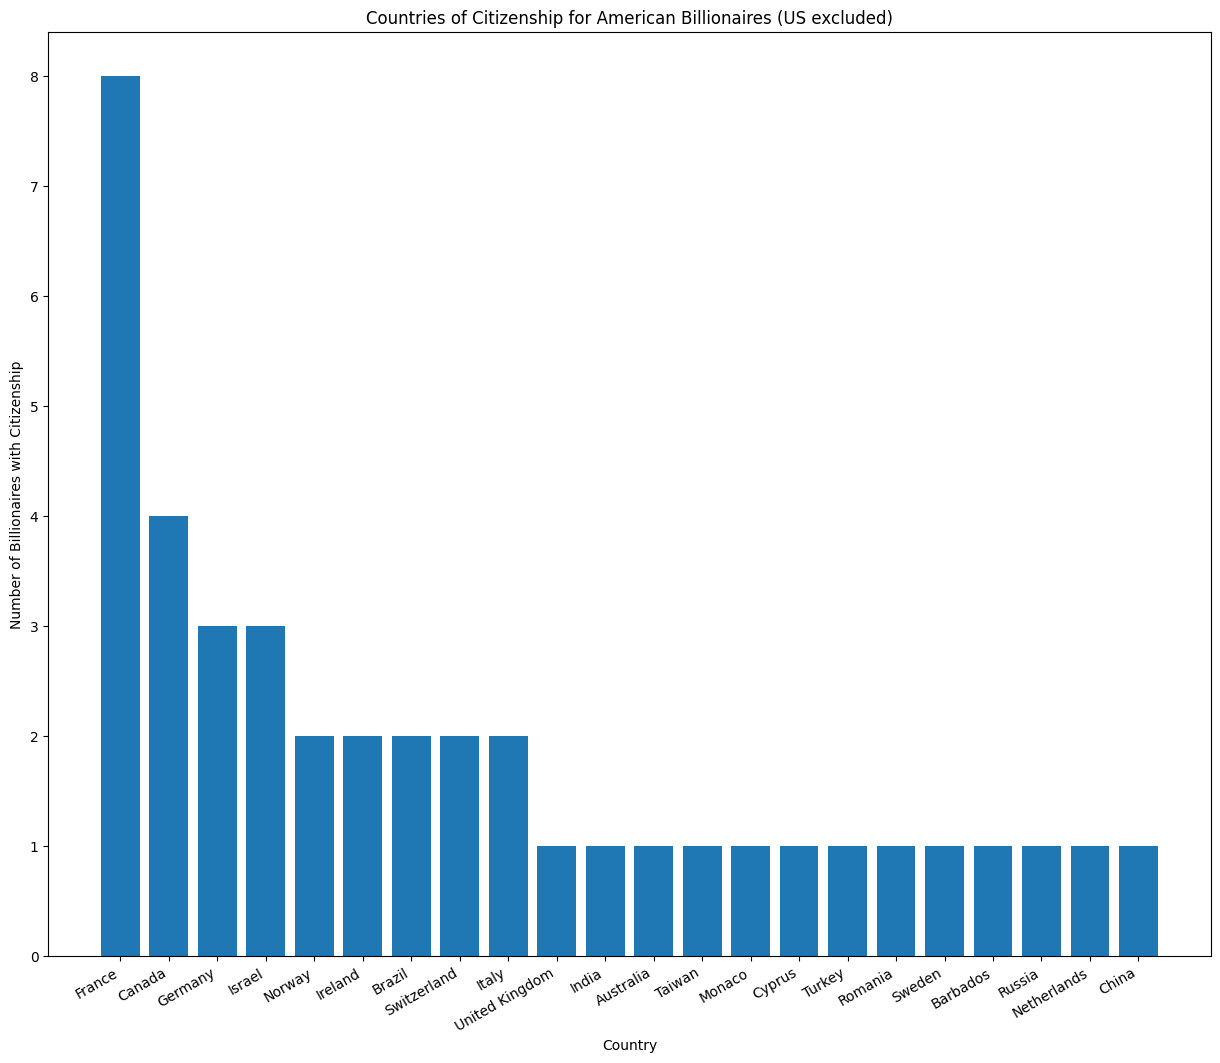

<Figure size 640x480 with 0 Axes>

In [8]:


#I also wanted to see how many billionaires that live in the United States consider themselves US Citizens
#The graph was limited to those with citizenship outside of the US since an overwhelming majority of US Billionaires live in the US

x = billionaires_cleaned.countryOfCitizenship[billionaires_cleaned.countryOfCitizenship != "United States"].unique()
y = billionaires_cleaned.countryOfCitizenship[billionaires_cleaned.countryOfCitizenship != "United States"].value_counts()

plt.figure(figsize=(15,12))
plt.bar(x, y)
plt.xticks(rotation=30, ha="right")
plt.xlabel("Country")
plt.ylabel("Number of Billionaires with Citizenship")
plt.title("Countries of Citizenship for American Billionaires (US excluded)")
plt.show()
plt.clf()

#It seems like most Billionaires who live in the US but don't have US Citizenship are French, Canadian, and German.
#Overall, it seems like most "outside" Billionaires are from North American and European regions and few are from Asian regions



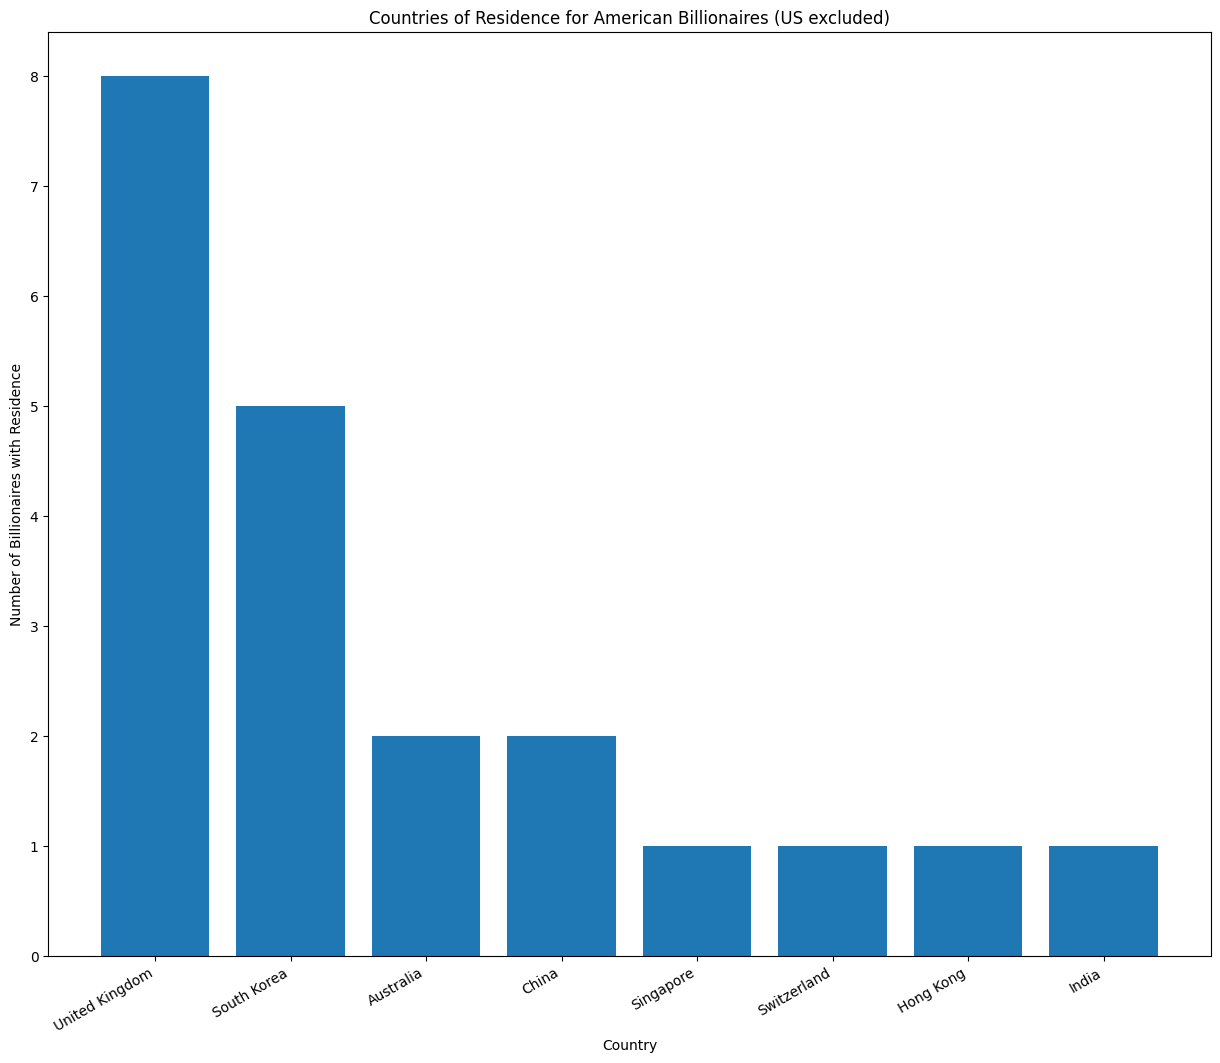

<Figure size 640x480 with 0 Axes>

In [9]:


#Following the previous analysis, I wanted to check where Billionaires that have US Citizenship live in the world.
#Again, those that have US citizenship and live in the United States were removed.

x = billionaires_cleaned.countryOfResidence[billionaires_cleaned.countryOfResidence != "United States"].unique()
y = billionaires_cleaned.countryOfResidence[billionaires_cleaned.countryOfResidence != "United States"].value_counts()

plt.figure(figsize=(15,12))
plt.bar(x, y)
plt.xticks(rotation=30, ha="right")
plt.xlabel("Country")
plt.ylabel("Number of Billionaires with Residence")
plt.title("Countries of Residence for American Billionaires (US excluded)")
plt.show()
plt.clf()

#It appears that US Billionaire Citizens that live outside the US usually live in the United Kingdom, South Korea, or Australia
#However, there doesn't appear to be too much of a bias towards a specific region like there was in the previous graph. US Billionaire Citizens live worldwide.



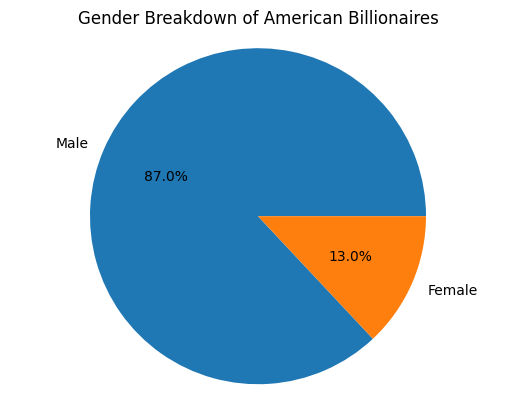

<Figure size 640x480 with 0 Axes>

In [10]:


#I wanted to see the gender breakdown of US Billionaires, so I created a pie chart.

x = billionaires_cleaned.gender.value_counts()
labels = ["Male", "Female"]

plt.pie(x, labels = labels, autopct="%1.1f%%")
plt.axis("equal")
plt.title("Gender Breakdown of American Billionaires")
plt.show()
plt.clf()

#It appears that most US Billionaires are men at an almost 9:1 ratio



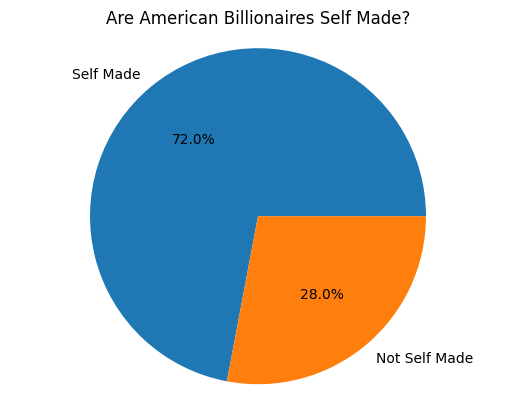

<Figure size 640x480 with 0 Axes>

In [11]:


#Finally, I wanted to see how many US Billionaires were "Self Made", meaning that their Billionaire status wasn't caused by someone giving them one billion dollars

x = billionaires_cleaned.selfMade.value_counts()
labels = ["Self Made", "Not Self Made"]

plt.pie(billionaires_cleaned.selfMade.value_counts(), labels = labels, autopct="%1.1f%%")
plt.axis("equal")
plt.title("Are American Billionaires Self Made?")
plt.show()
plt.clf()

#It appears that 72% of US Billionaires are Self-Made, while 28% are not.


While these graphs are okay, I'd like to represent this data using Tableau to create an interactive visualization. This means I'll have to save my cleaned dataframe as a csv file so that it can be opened in Tableau.

In [12]:
billionaires_cleaned.to_csv("Cleaned US Billionaires Dataset3.csv")